# IMPORT LIBRARY

In [11]:
import faulthandler 
from pyspark.sql import SparkSession 
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import ArrayType, DoubleType, BooleanType, DateType, FloatType, TimestampType
from pyspark.sql.functions import col, array_contains, isnan, when, count
from pyspark.sql.functions import lit, concat_ws, concat, collect_list, udf
from pyspark.sql.functions import countDistinct
import plotly.express as px
import os

## spark 접속

In [12]:

faulthandler.enable()   
spark = SparkSession.builder.master('local').appName('Python Spark SQL Practice').getOrCreate()

# DATA LOAD

In [13]:
def search(dirname):
    filenames = os.listdir(dirname)
    file_list = []
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)
        print(full_filename)
        file_list.append(full_filename)
    return file_list
data_path_list = search("D:/workspace/data/")

D:/workspace/data/2019-Dec.csv
D:/workspace/data/2019-Nov.csv
D:/workspace/data/2019-Oct.csv
D:/workspace/data/2020-Apr.csv
D:/workspace/data/2020-Feb.csv
D:/workspace/data/2020-Jan.csv
D:/workspace/data/2020-Mar.csv


## 스키마 타입

In [14]:
schema = StructType() \
      .add("event_time",TimestampType(),True) \
      .add("event_type",StringType(),True) \
      .add("product_id",StringType(),True) \
      .add("category_id",StringType(),True) \
      .add("category_code",StringType(),True) \
      .add("brand",StringType(),True) \
      .add("price",DoubleType(),True) \
      .add("user_id",StringType(),True) \
      .add("user_session",StringType(),True)

## DATA MERGE
    - 2019년 10월 ~ 2020년 4월

In [15]:
for i, x in enumerate(data_path_list):
    file_path = x
    df = spark.read.format("csv") \
      .option("header", True) \
      .option('delimiter', ',') \
      .schema(schema) \
      .load(file_path)
    if i == 0:
        merged_df = df
    else:
        merged_df = merged_df.union(df)

In [16]:
merged_df.show()

+-------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|2019-12-01 09:00:00|      view|   1005105|2232732093077520756|construction.tool...|  apple|1302.48|556695836|ca5eefc5-11f9-450...|
|2019-12-01 09:00:00|      view|  22700068|2232732091643068746|                NULL|  force| 102.96|577702456|de33debe-c7bf-44e...|
|2019-12-01 09:00:01|      view|   2402273|2232732100769874463|appliances.person...|  bosch| 313.52|539453785|5ee185a7-0689-4a3...|
|2019-12-01 09:00:02|  purchase|  26400248|2053013553056579841|computers.periphe...|   NULL| 132.31|535135317|61792a26-672f-4e6...|
|2019-12-01 09:00:02|      view|  20100164|2232732110089618156|    apparel.t

## spark table 생성

In [17]:
merged_df.createOrReplaceTempView("ecommerce")

# 1. 카테코리 id가 NULL 값인 것들

In [18]:
eda1 = spark.sql("""SELECT COUNT(*) AS CNT
FROM ecommerce
WHERE category_id is NULL""")

In [19]:
eda1.show()

+---+
|CNT|
+---+
|  0|
+---+



# 2. remove_from_cart 항목이 있는지 여부

In [20]:
eda2 = spark.sql("""SELECT COUNT(*) AS CNT
FROM ecommerce
WHERE event_type = 'remove_from_cart'""")

In [21]:
eda2.show()

+---+
|CNT|
+---+
|  0|
+---+



# 3. 카테고리 아이디 별 평균 물품 금액

In [22]:
eda3 = spark.sql("""SELECT category_id, category_code, AVG(price) AS AVG_PRICE_PER_CATEGORY
FROM ecommerce
GROUP BY category_code, category_id""")

In [23]:
eda3.show()

+-------------------+--------------------+----------------------+
|        category_id|       category_code|AVG_PRICE_PER_CATEGORY|
+-------------------+--------------------+----------------------+
|2085718636156158307|                NULL|       89.357837718524|
|2232732071460078545|           kids.toys|     236.9504976051201|
|2232732117446427558|       apparel.shoes|    12.573163469161257|
|2232732127479201950|     accessories.bag|    49.233197263043266|
|2116907524488691805|  apparel.shoes.keds|     40.38535449020932|
|2134905045328592909|                NULL|     41.40644277624123|
|2053013555287949705|computers.periphe...|     78.61038170940279|
|2232732097775141341|  apparel.shoes.keds|     94.98465342374284|
|2053013561638126333|       apparel.shirt|      97.4129274128394|
|2232732101667455537|apparel.shoes.sli...|    31.390266871594235|
|2136935916512478049|appliances.kitche...|    14.401044362292062|
|2152167773222993940|                NULL|     260.6987540917275|
|223273208

In [49]:
eda3_1 = spark.sql("""SELECT SUBSTRING_INDEX(category_code, '.', 1) AS CATEGORY_NAME, AVG(price) AS AVG_PRICE_PER_CATEGORY
                   FROM ecommerce
                   GROUP BY CATEGORY_NAME
                   ORDER BY AVG_PRICE_PER_CATEGORY DESC""")

In [50]:
eda3_1.show()

+-------------+----------------------+
|CATEGORY_NAME|AVG_PRICE_PER_CATEGORY|
+-------------+----------------------+
| construction|    409.28852297369133|
|  electronics|    387.81088545528655|
|    computers|     329.3847580941643|
|   appliances|    286.52057920415064|
|    furniture|     199.1557258011355|
|         auto|    187.71310000474847|
|         NULL|     176.5220760161219|
|      apparel|     170.8177042088896|
|         kids|     148.2903440499196|
|        sport|    140.73326591496777|
|  accessories|    101.11124819544531|
|   stationery|      73.4982119205298|
| country_yard|    48.430079208453265|
|     medicine|    37.186099641824086|
+-------------+----------------------+



# 4. 카테고리 아이디 별 평균 구매 물품 금액

In [47]:
eda4 = spark.sql("""SELECT category_id, category_code, AVG(price) AS AVG_PRICE_PER_CATEGORY
FROM ecommerce
WHERE event_type = 'purchase'
GROUP BY category_id, category_code""")

In [48]:
eda4.show()

+-------------------+--------------------+----------------------+
|        category_id|       category_code|AVG_PRICE_PER_CATEGORY|
+-------------------+--------------------+----------------------+
|2232732100056842769|appliances.person...|    234.32060506050593|
|2232732106004365963|appliances.kitche...|     36.28692821368948|
|2232732092490318178|   computers.desktop|    149.55282738095238|
|2152167773222993940|                NULL|    303.84773353751905|
|2053013565069067197|  apparel.shoes.keds|     79.62387194462465|
|2232732105014510203|        apparel.sock|    57.306927710843375|
|2053013561604571899|     apparel.costume|     34.23494071146245|
|2232732107212325539|                NULL|     318.5766890756304|
|2232732109418529498|       apparel.shirt|    42.791333677952956|
|2053013565882762215|      apparel.jumper|     46.81646706586828|
|2053013557133443581|furniture.living_...|    229.29584145549072|
|2232732082642092168|                NULL|    112.58361111111097|
|223273210

In [51]:
eda4_1 = spark.sql("""SELECT SUBSTRING_INDEX(category_code, '.', 1) AS CATEGORY_NAME, AVG(price) AS AVG_PRICE_PER_CATEGORY
                   FROM ecommerce
                   WHERE event_type = 'purchase'
                   GROUP BY CATEGORY_NAME
                   ORDER BY AVG_PRICE_PER_CATEGORY DESC""")

In [52]:
eda4_1.show()

+-------------+----------------------+
|CATEGORY_NAME|AVG_PRICE_PER_CATEGORY|
+-------------+----------------------+
| construction|    412.94903674811064|
|  electronics|    381.14751104844305|
|   appliances|     256.0273941494742|
|    computers|    246.97784373208972|
|         auto|     186.0839782307905|
|      apparel|    137.36531453543282|
|        sport|    131.28760921190346|
|         NULL|     129.9935872197483|
|    furniture|    117.08375112033822|
|         kids|    113.66340742557878|
|   stationery|      66.3247115384615|
|  accessories|     64.39932897378849|
| country_yard|    35.865017052262864|
|     medicine|     29.97154084397988|
+-------------+----------------------+



# 5. 월별 USER 수

In [26]:
eda5 = spark.sql("""
                               SELECT MONTH(event_time) AS MONTH, COUNT(DISTINCT user_id) AS CNT
                              FROM ecommerce
                              GROUP BY MONTH
                          """)



In [27]:
eda5.show()

+-----+-------+
|MONTH|    CNT|
+-----+-------+
|   12|4568466|
|    1|4387144|
|    3|4116768|
|    5| 125161|
|    4|4493564|
|   10|3003621|
|   11|3690591|
|    2|4241163|
+-----+-------+



# 6. EVENT_TYPE 비율

In [28]:
eda6 = spark.sql("SELECT event_type, count(*) AS count FROM ecommerce GROUP BY event_type")

In [29]:
eda6.show()

+----------+---------+
|event_type|    count|
+----------+---------+
|  purchase|  6848824|
|      view|385746849|
|      cart| 19114063|
+----------+---------+



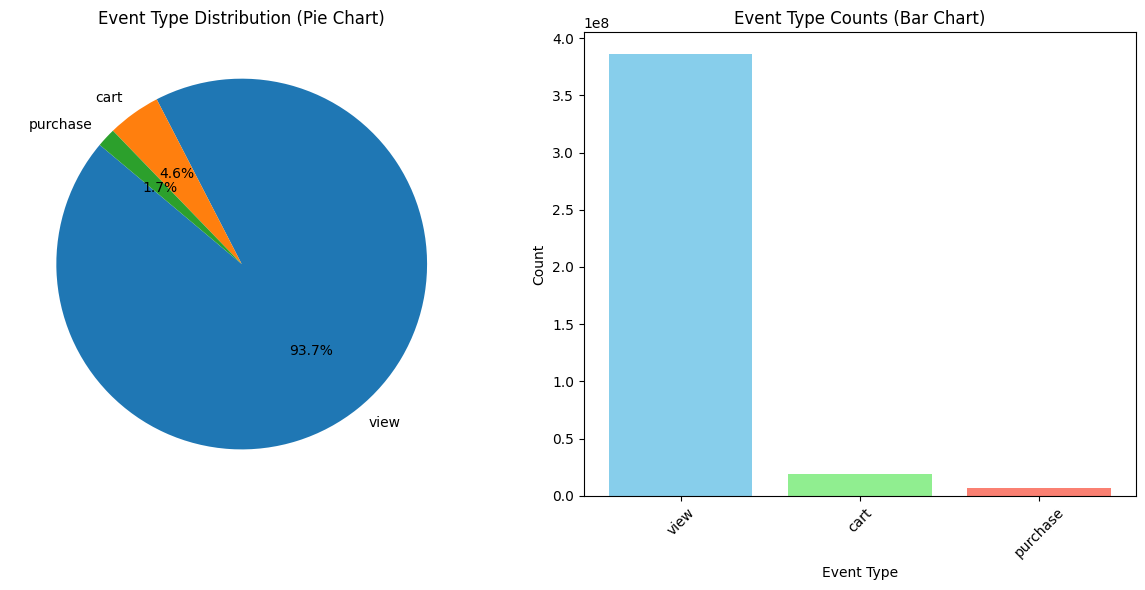

In [30]:
import matplotlib.pyplot as plt

# Spark DataFrame을 Pandas DataFrame으로 변환
pandas_df = eda6.toPandas()

# 이벤트 타입을 view -> cart -> purchase 순으로 정렬
pandas_df = pandas_df.set_index('event_type').reindex(['view', 'cart', 'purchase']).reset_index()

# 원 그래프 생성
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 첫 번째 그래프는 원 그래프
plt.pie(pandas_df['count'], labels=pandas_df['event_type'], autopct='%1.1f%%', startangle=140)
plt.title('Event Type Distribution (Pie Chart)')

# 막대 그래프 생성
plt.subplot(1, 2, 2)  # 두 번째 그래프는 막대 그래프
plt.bar(pandas_df['event_type'], pandas_df['count'], color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Event Type Counts (Bar Chart)')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

# 그래프 보여주기
plt.tight_layout()
plt.show()


# 7. user_session 별 view, purchase, cart의 수

In [31]:
eda7 = spark.sql('''WITH source AS (
                                                SELECT user_session, event_type, COUNT(event_time) AS event_count
                                                FROM ecommerce
                                                GROUP BY user_session, event_type
                                                )
                            SELECT 
                                user_session,
                                SUM(CASE WHEN event_type = 'view' THEN event_count ELSE 0 END) AS view,
                                SUM(CASE WHEN event_type = 'cart' THEN event_count ELSE 0 END) AS cart,
                                SUM(CASE WHEN event_type = 'purchase' THEN event_count ELSE 0 END) AS purchase
                            FROM source
                            GROUP BY user_session
                            ORDER BY user_session
                        ''')

In [32]:
eda7.show()

+--------------------+----+----+--------+
|        user_session|view|cart|purchase|
+--------------------+----+----+--------+
|                NULL|  90| 132|       4|
|00000031-5225-42a...|   1|   0|       0|
|00000042-3e3f-42f...|   2|   0|       0|
|0000004b-b485-4bf...|   2|   0|       0|
|00000056-a206-40d...|   8|   0|       0|
|0000007c-adbf-4ed...|   1|   0|       0|
|00000083-8816-4d5...|  16|   1|       1|
|0000009d-1f5b-40b...|   1|   0|       0|
|00000108-fa90-4bf...|   1|   0|       0|
|0000013c-0ccc-4b8...|   1|   0|       0|
|00000162-3f83-4d1...|   2|   0|       0|
|000001d5-66f5-4fa...|   1|   0|       0|
|000001d5-f8f8-4e4...|   1|   0|       0|
|000001fd-1f89-45e...|   6|   4|       1|
|00000208-b6b8-44c...|   1|   0|       0|
|0000020c-8e6b-4d2...|   1|   0|       0|
|00000214-9e7b-4dd...|  16|   0|       0|
|0000022a-fe95-430...|   3|   0|       0|
|00000241-5dac-4d3...|   1|   0|       0|
|00000348-8463-483...|   1|   0|       0|
+--------------------+----+----+--

# 8. user_session의 NULL 여부 및 수

In [33]:
eda8 = spark.sql("""
SELECT COUNT(*) AS CNT
FROM ecommerce
WHERE user_session is NULL
""")

In [34]:
eda8.show()

+---+
|CNT|
+---+
|226|
+---+



# 9. 카테고리 갯수

## 카테고리 대분류

In [35]:
eda9_1 = spark.sql("""SELECT DISTINCT (SUBSTRING_INDEX(category_code, '.', 1)) 
                   FROM ecommerce""")

In [36]:
eda9_1.show()

+------------------------------------+
|substring_index(category_code, ., 1)|
+------------------------------------+
|                            medicine|
|                           computers|
|                                auto|
|                          stationery|
|                               sport|
|                             apparel|
|                          appliances|
|                        country_yard|
|                           furniture|
|                         accessories|
|                                kids|
|                         electronics|
|                        construction|
|                                NULL|
+------------------------------------+



## 대분류 갯수

In [37]:
eda9_2 = spark.sql("""SELECT COUNT(DISTINCT (SUBSTRING_INDEX(category_code, '.', 1))) AS CNT 
                   FROM ecommerce""")

In [38]:
eda9_2.show()

+---+
|CNT|
+---+
| 13|
+---+



## 카테고리 중분류

In [39]:
eda9_3= spark.sql("""SELECT DISTINCT (SUBSTRING_INDEX(category_code, '.', 2)) AS cnt 
          FROM ecommerce""")

In [40]:
eda9_3.show()

+--------------------+
|                 cnt|
+--------------------+
|  electronics.camera|
|    computers.ebooks|
|  furniture.bathroom|
|country_yard.furn...|
|     sport.snowboard|
|       apparel.shirt|
|  electronics.tablet|
|       apparel.jeans|
|   electronics.audio|
| stationery.cartrige|
|electronics.telep...|
|     apparel.pajamas|
|       apparel.skirt|
|      apparel.jacket|
|       apparel.dress|
|     accessories.bag|
|       sport.bicycle|
|         kids.skates|
|   apparel.underwear|
|       apparel.scarf|
+--------------------+
only showing top 20 rows



## 카테고리 중분류 갯수

In [41]:
eda9_4 = spark.sql("""SELECT COUNT(DISTINCT (SUBSTRING_INDEX(category_code, '.', 2))) AS cnt 
          FROM ecommerce""")

In [42]:
eda9_4.show()

+---+
|cnt|
+---+
| 66|
+---+



# 10. 요일별 판매량, 판매액, paying User
DAYOFWEEK => 일요일 1, 월요일 2, 화요일 3, 수요일 4, 목요일 5, 금요일 6, 토요일 7

In [43]:
eda10 = spark.sql("""
                                SELECT CASE DAYOFWEEK(event_time)
                                            WHEN '1' THEN 'SUN'
                                            WHEN '2' THEN 'MON'
                                            WHEN '3' THEN 'TUE'
                                            WHEN '4' THEN 'WED'
                                            WHEN '5' THEN 'THU' 
                                            WHEN '6' THEN 'FRI' 
                                            WHEN '7' THEN 'SAT' 
                                        END
                                                AS dayOfweek,
                                        COUNT(*) AS total_sales_amount,
                                        FLOOR(SUM(price)) AS total_sales_price,
                                        COUNT(DISTINCT user_id) AS paying_user_cnt
                                FROM ecommerce
                                WHERE event_type = 'purchase'
                                GROUP BY dayOfweek
                                ORDER BY total_sales_amount DESC
                             """)

In [44]:
eda10.show()

+---------+------------------+-----------------+---------------+
|dayOfweek|total_sales_amount|total_sales_price|paying_user_cnt|
+---------+------------------+-----------------+---------------+
|      SUN|           1055228|        313085547|         559699|
|      MON|           1013977|        307931292|         524147|
|      SAT|            980182|        292239436|         523776|
|      WED|            963658|        291715085|         506306|
|      THU|            956283|        286149186|         506407|
|      FRI|            942724|        283230299|         500212|
|      TUE|            936772|        283096380|         492408|
+---------+------------------+-----------------+---------------+



# 11. 월별 판매량, 판매액, paying User

In [45]:
eda11 = spark.sql("""
                                SELECT MONTH(event_time) AS MONTH,
                                        COUNT(*) AS total_sales_amount,
                                        FLOOR(SUM(price)) AS total_sales_price,
                                        COUNT(DISTINCT user_id) AS paying_user_cnt
                                FROM ecommerce
                                WHERE event_type = 'purchase'
                                GROUP BY MONTH
                                ORDER BY total_sales_amount DESC
                             """)

In [46]:
eda11.show()

+-----+------------------+-----------------+---------------+
|MONTH|total_sales_amount|total_sales_price|paying_user_cnt|
+-----+------------------+-----------------+---------------+
|    2|           1202425|        381733526|         392986|
|   12|           1166126|        345350267|         502203|
|    3|           1025438|        321543985|         453238|
|    4|            961924|        243801633|         483209|
|   11|            914915|        274656223|         440842|
|    1|            829470|        259480355|         357440|
|   10|            737955|        228396975|         345250|
|    5|             10571|          2484260|           7510|
+-----+------------------+-----------------+---------------+



# SPARK STOP

In [ ]:
spark.stop()